In [1]:
%load_ext autoreload

# Anomaly Detection Refinements

## IPOC measurement lengths

IPOC triggers can be 10 seconds apart.
But how long does each measurment "cycle" last?

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = db.query("MKI.UA23.IPOC.AB1:T_LENGTH")
display(df.head())

df["timestamps"] = df.index.round("S")
display(df.head())

Fetching data for pattern MKI.UA23.IPOC.AB1:T_LENGTH from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH


MKI.UA23.IPOC.AB1:T_LENGTH
2016-04-17 00:50:36.358                      2.0815
2016-04-17 00:50:46.358                      2.0846
2016-04-17 00:50:56.358                      2.0842
2016-04-17 00:51:06.358                      2.0851
2016-04-17 00:51:16.357                      2.0840

MKI.UA23.IPOC.AB1:T_LENGTH          timestamps
2016-04-17 00:50:36.358                      2.0815 2016-04-17 00:50:36
2016-04-17 00:50:46.358                      2.0846 2016-04-17 00:50:46
2016-04-17 00:50:56.358                      2.0842 2016-04-17 00:50:56
2016-04-17 00:51:06.358                      2.0851 2016-04-17 00:51:06
2016-04-17 00:51:16.357                      2.0840 2016-04-17 00:51:16

### Visually

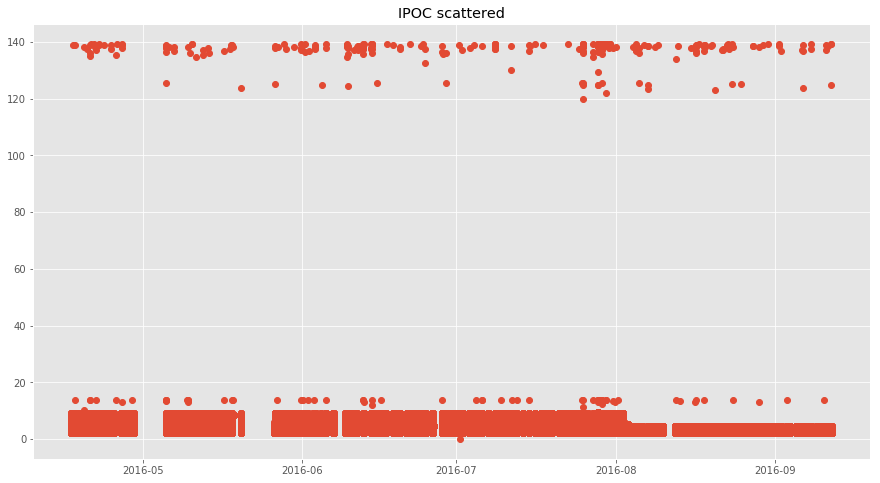

In [4]:
plt.plot_date(x=df["timestamps"], y=df["MKI.UA23.IPOC.AB1:T_LENGTH"])
plt.title("IPOC scattered")

Hard to detect visually, only long gaps can be detected.

### Code

IPOC segments are ended when the time between 2 IPOC measurements exceeds X minutes. Not counting clusters of 
length 1 (isolated IPOC measurements).

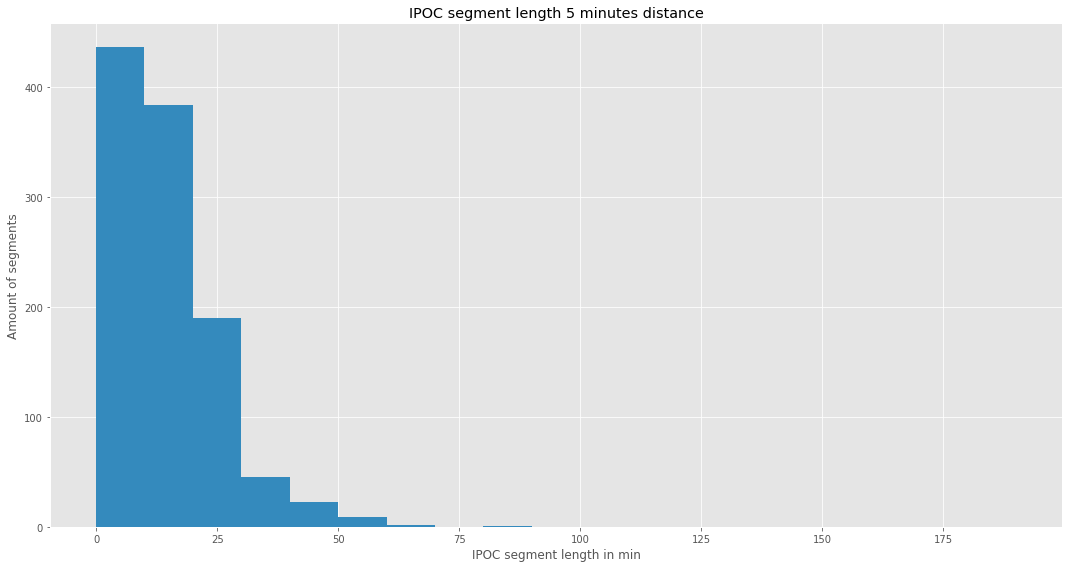

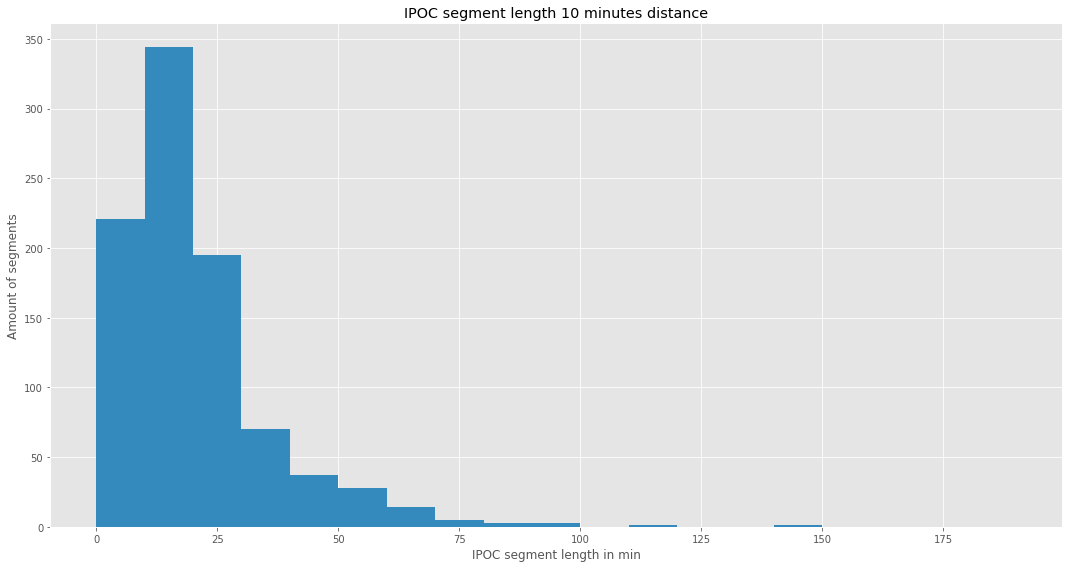

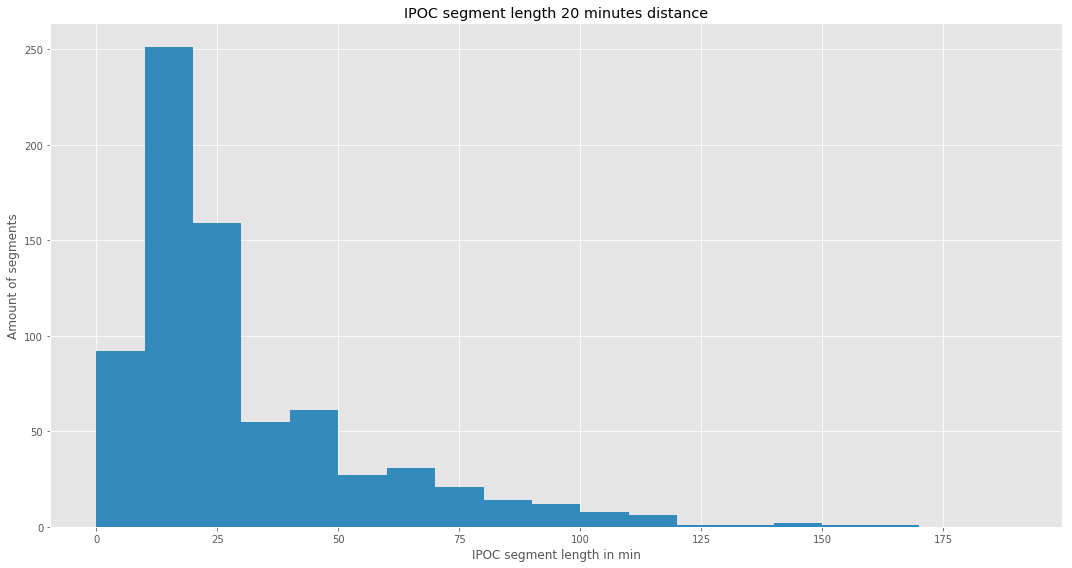

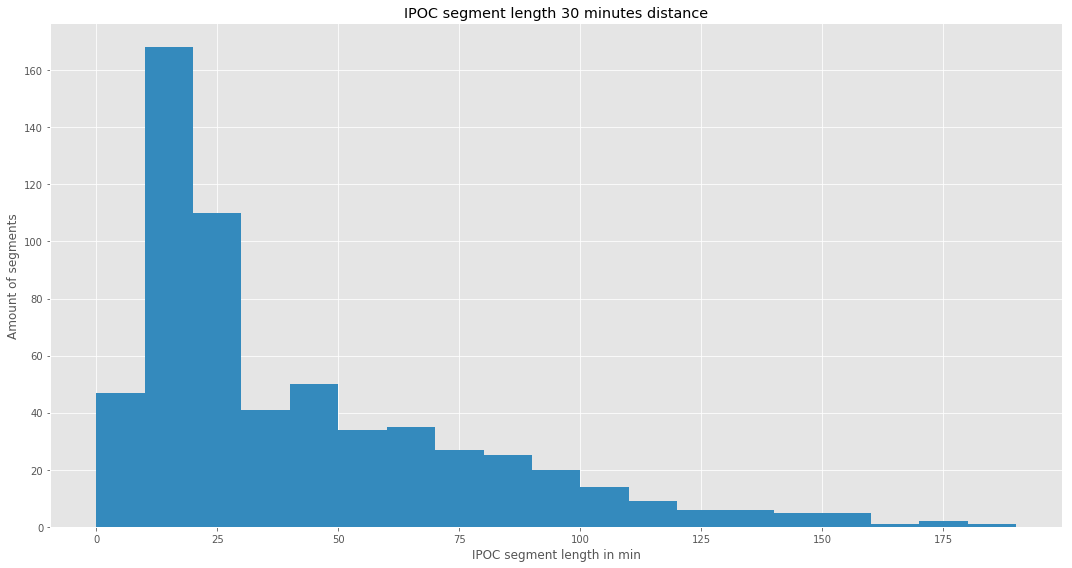

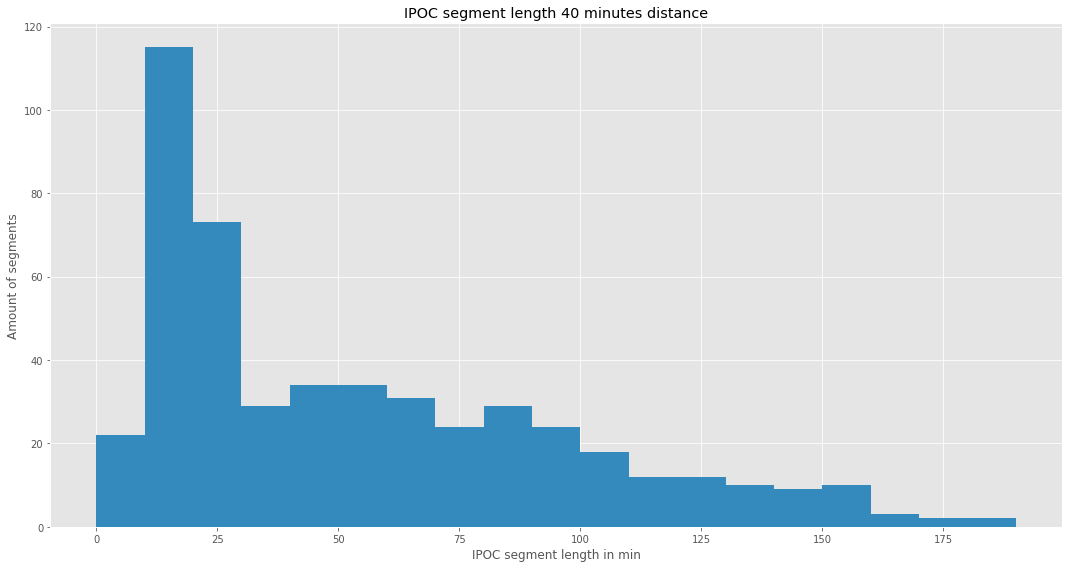

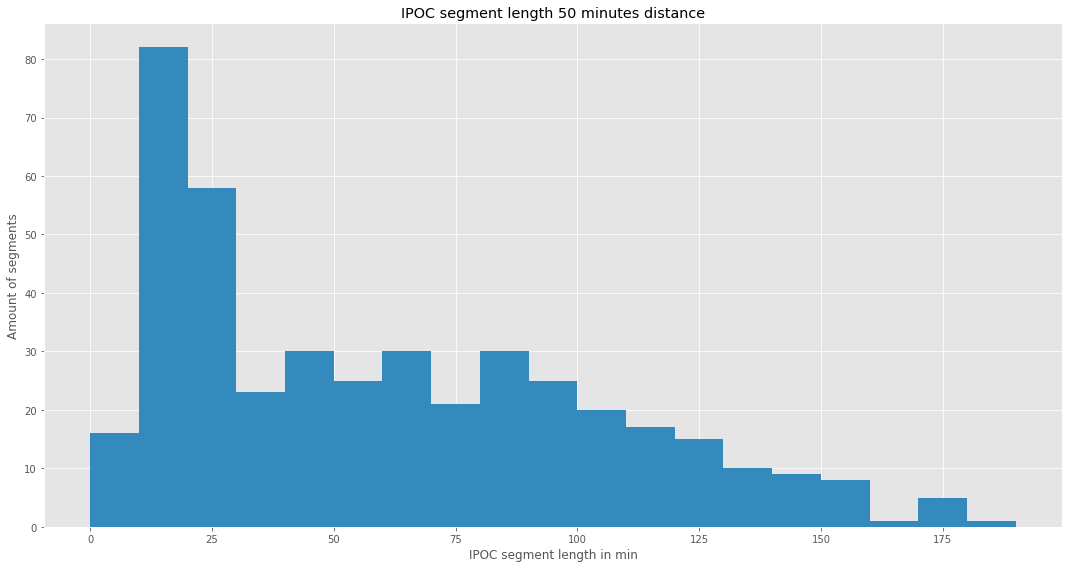

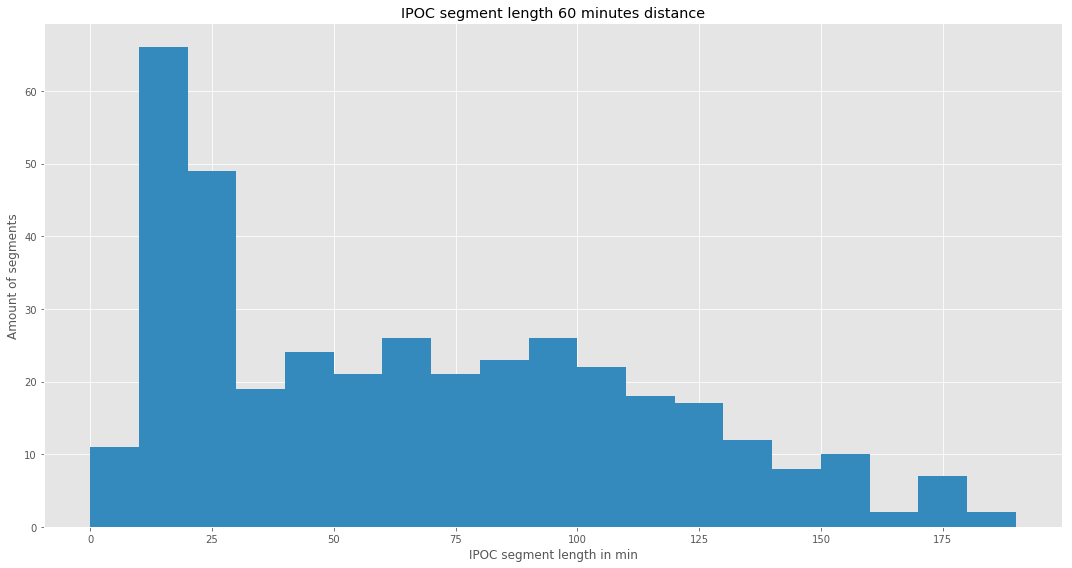

In [23]:
for minutes_distance in [5, 10, 20, 30, 40, 50, 60]:
    plot.features.ipoc_segment_length_histogram(df, minutes_distance, "IPOC segment length {} minutes distance".format(minutes_distance))

From this figure it seems better to expand the sliding windows to 20 minutes. Next step is to check the variation in the sliding windows over each cluster.

## Inspecting Anomalies

Get elogbook entries

In [6]:
ELB = db.query("MKI.ELOGBOOK_tagged")
display(ELB.head())
ELB = ELB.join(ELB['MKI.ELOGBOOK_tagged'].apply(pd.Series))
ELB.drop('MKI.ELOGBOOK_tagged', axis=1, inplace=True)
# ELB.drop("C0", axis=1, inplace=True)
ELB["marker"] = 0
display(ELB.shape, ELB.head())

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


MKI.ELOGBOOK_tagged
2016-04-23 04:00:00  {'TAG': 'fault', 'EVENTDATE': '23/04/2016 06:0...
2016-04-23 10:15:28  {'TAG': 'fault', 'EVENTDATE': '23/04/2016 12:1...
2016-04-24 05:19:36  {'TAG': 'fault', 'EVENTDATE': '24/04/2016 07:1...
2016-04-24 12:03:20  {'TAG': 'fault', 'EVENTDATE': '24/04/2016 14:0...
2016-04-26 10:00:00  {'TAG': 'research', 'EVENTDATE': '26/04/2016 1...

(102, 9)

C0            EVENTDATE EVENT_ID      PATH  \
2016-04-23 04:00:00  1  23/04/2016 06:00:00  2098246  LHC.MKI8   
2016-04-23 10:15:28  2  23/04/2016 12:15:28  2098379  LHC.MKI8   
2016-04-24 05:19:36  3  24/04/2016 07:19:36  2098811  LHC.MKI8   
2016-04-24 12:03:20  4  24/04/2016 14:03:20  2098949  LHC.MKI8   
2016-04-26 10:00:00  5  26/04/2016 12:00:00  2100547  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
2016-04-23 04:00:00  Piquet contact me for the MKI8 problem with th...   
2016-04-23 10:15:28  At the same moment as the LBDS XPOC fault, the...   
2016-04-24 05:19:36  CCC LHC calls for MKI8 faulty. Same problem as...   
2016-04-24 12:03:20  CCC calls, again SVM fault for KTC6 rack. I tr...   
2016-04-26 10:00:00  High vacuum in MKI8d-Q5 interconnect during sc...   

                          TAG                   USERNAME VALUE  marker  
2016-04-23 04:00:00     fault  christophe.boucly@cern.ch  MKI8       0  
2016-04-23 10:15:28     fault                   pvantrap  MKI8       0  
2016-04-24 05:19:36     fault                   pvantrap  MKI8       0  
2016-04-24 12:03:20     fault                   pvantrap  MKI8       0  
2016-04-26 10:00:00  research        mike.barnes@cern.ch  MKI8       0

There are duplicate entries:

In [7]:
display(ELB[ELB.index.duplicated()])

display(ELB[ELB["EVENT_ID"] == "2123726"], ELB[ELB["EVENT_ID"] == "2123724"])

C0            EVENTDATE EVENT_ID      PATH  \
2016-06-07 09:39:00  27  07/06/2016 11:39:00  2123726  LHC.MKI8   
2016-06-07 09:39:00  25  07/06/2016 11:39:00  2123724  LHC.MKI2   
2016-06-07 09:39:00  27  07/06/2016 11:39:00  2123726  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
2016-06-07 09:39:00  Gael and Denis checked RG220 cables from MS PF...   
2016-06-07 09:39:00  Added the following feature in WinCC trends:\n...   
2016-06-07 09:39:00  Gael and Denis checked RG220 cables from MS PF...   

                              TAG                     USERNAME VALUE  marker  
2016-06-07 09:39:00  intervention          mike.barnes@cern.ch  MKI8       0  
2016-06-07 09:39:00          info  roger.andrew.barlow@cern.ch  MKI2       0  
2016-06-07 09:39:00  intervention          mike.barnes@cern.ch  MKI8       0

C0            EVENTDATE EVENT_ID      PATH  \
2016-06-07 09:39:00  27  07/06/2016 11:39:00  2123726  LHC.MKI8   
2016-06-07 09:39:00  27  07/06/2016 11:39:00  2123726  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
2016-06-07 09:39:00  Gael and Denis checked RG220 cables from MS PF...   
2016-06-07 09:39:00  Gael and Denis checked RG220 cables from MS PF...   

                              TAG             USERNAME VALUE  marker  
2016-06-07 09:39:00  intervention  mike.barnes@cern.ch  MKI8       0  
2016-06-07 09:39:00  intervention  mike.barnes@cern.ch  MKI8       0

C0            EVENTDATE EVENT_ID      PATH  \
2016-06-07 09:39:00  25  07/06/2016 11:39:00  2123724  LHC.MKI2   
2016-06-07 09:39:00  25  07/06/2016 11:39:00  2123724  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_   TAG  \
2016-06-07 09:39:00  Added the following feature in WinCC trends:\n...  info   
2016-06-07 09:39:00  Added the following feature in WinCC trends:\n...  info   

                                        USERNAME VALUE  marker  
2016-06-07 09:39:00  roger.andrew.barlow@cern.ch  MKI2       0  
2016-06-07 09:39:00  roger.andrew.barlow@cern.ch  MKI2       0

Fetch entries with other method

In [9]:
ELB2 = db.query_elogbook()
ELB2["marker"] = 0
display(ELB2.shape, ELB2.head())

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


(100, 9)

C0            EVENTDATE EVENT_ID      PATH  \
2016-04-23 04:00:00  1  23/04/2016 06:00:00  2098246  LHC.MKI8   
2016-04-23 10:15:28  2  23/04/2016 12:15:28  2098379  LHC.MKI8   
2016-04-24 05:19:36  3  24/04/2016 07:19:36  2098811  LHC.MKI8   
2016-04-24 12:03:20  4  24/04/2016 14:03:20  2098949  LHC.MKI8   
2016-04-26 10:00:00  5  26/04/2016 12:00:00  2100547  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
2016-04-23 04:00:00  Piquet contact me for the MKI8 problem with th...   
2016-04-23 10:15:28  At the same moment as the LBDS XPOC fault, the...   
2016-04-24 05:19:36  CCC LHC calls for MKI8 faulty. Same problem as...   
2016-04-24 12:03:20  CCC calls, again SVM fault for KTC6 rack. I tr...   
2016-04-26 10:00:00  High vacuum in MKI8d-Q5 interconnect during sc...   

                          TAG                   USERNAME VALUE  marker  
2016-04-23 04:00:00     fault  christophe.boucly@cern.ch  MKI8       0  
2016-04-23 10:15:28     fault                   pvantrap  MKI8       0  
2016-04-24 05:19:36     fault                   pvantrap  MKI8       0  
2016-04-24 12:03:20     fault                   pvantrap  MKI8       0  
2016-04-26 10:00:00  research        mike.barnes@cern.ch  MKI8       0

Fetch anomaly entries

In [13]:
anom = ELB[ELB["TAG"] == "anomaly"]
display(anom.shape, anom.head())

(16, 9)

C0            EVENTDATE EVENT_ID      PATH  \
2016-05-30 14:00:00  17  30/05/2016 16:00:00  2118913  LHC.MKI8   
2016-06-05 17:18:00  22  05/06/2016 19:18:00  2122744  LHC.MKI8   
2016-06-18 19:59:00  33  18/06/2016 21:59:00  2130953  LHC.MKI8   
2016-06-19 13:14:00  34  19/06/2016 15:14:00  2131267  LHC.MKI2   
2016-06-30 21:23:00  39  30/06/2016 23:23:00  2138252  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_  \
2016-05-30 14:00:00  MKI.UA87.IPOC.AB2 Fall Time IQC check had been...   
2016-06-05 17:18:00  Thomas called me, following a call from the CC...   
2016-06-18 19:59:00  CCC called at 21:08 for a VAC INTERCONNECT int...   
2016-06-19 13:14:00  CCC called at 14h55 for a fault on MKI2.\nThe ...   
2016-06-30 21:23:00  Spark on MKI2B during SS at 51.2kV and 2.8us\n...   

                         TAG                    USERNAME VALUE  marker  
2016-05-30 14:00:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-05 17:18:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-18 19:59:00  anomaly  christophe.lolliot@cern.ch  MKI8       0  
2016-06-19 13:14:00  anomaly  christophe.lolliot@cern.ch  MKI2       0  
2016-06-30 21:23:00  anomaly         mike.barnes@cern.ch  MKI2       0

In [14]:
anom2 = db.query_elogbook_anomalies()
anom2["marker"] = 0
display(anom2.shape, anom2.head())

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


(16, 9)

C0            EVENTDATE EVENT_ID      PATH  \
2016-05-30 14:00:00  17  30/05/2016 16:00:00  2118913  LHC.MKI8   
2016-06-05 17:18:00  22  05/06/2016 19:18:00  2122744  LHC.MKI8   
2016-06-18 19:59:00  33  18/06/2016 21:59:00  2130953  LHC.MKI8   
2016-06-19 13:14:00  34  19/06/2016 15:14:00  2131267  LHC.MKI2   
2016-06-30 21:23:00  39  30/06/2016 23:23:00  2138252  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_  \
2016-05-30 14:00:00  MKI.UA87.IPOC.AB2 Fall Time IQC check had been...   
2016-06-05 17:18:00  Thomas called me, following a call from the CC...   
2016-06-18 19:59:00  CCC called at 21:08 for a VAC INTERCONNECT int...   
2016-06-19 13:14:00  CCC called at 14h55 for a fault on MKI2.\nThe ...   
2016-06-30 21:23:00  Spark on MKI2B during SS at 51.2kV and 2.8us\n...   

                         TAG                    USERNAME VALUE  marker  
2016-05-30 14:00:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-05 17:18:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-18 19:59:00  anomaly  christophe.lolliot@cern.ch  MKI8       0  
2016-06-19 13:14:00  anomaly  christophe.lolliot@cern.ch  MKI2       0  
2016-06-30 21:23:00  anomaly         mike.barnes@cern.ch  MKI2       0

In [15]:
anom2.equals(anom)

True

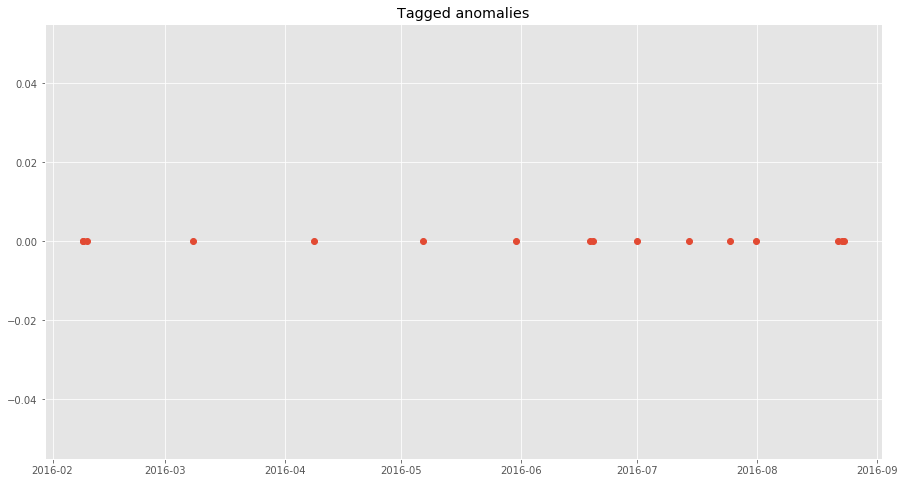

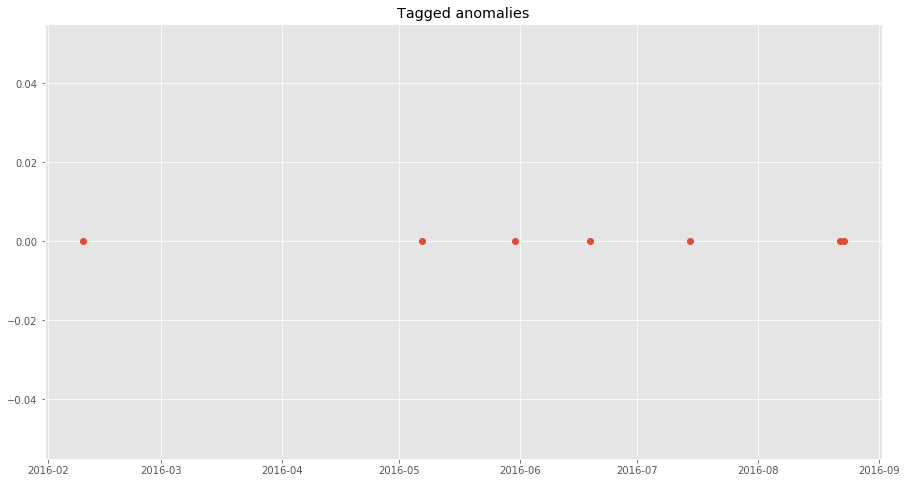

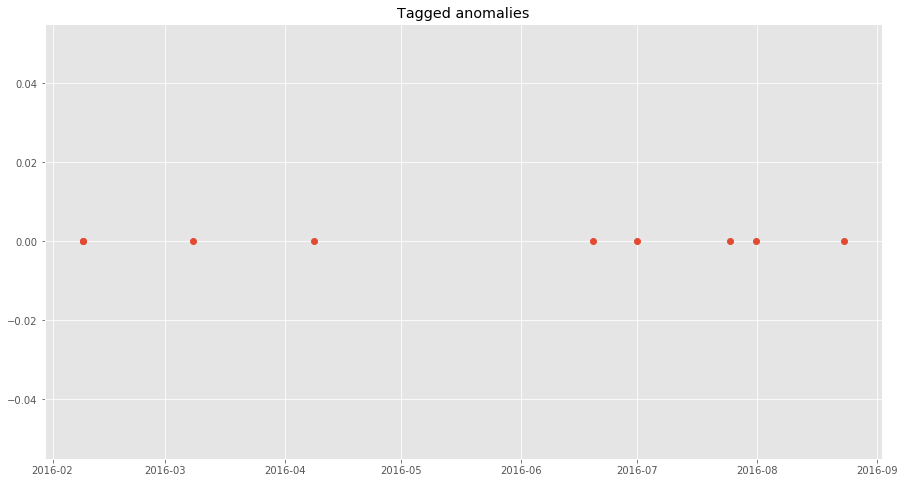

In [22]:
b1 = anom2[anom2["VALUE"] == "MKI8"]
b2 = anom2[anom2["VALUE"] == "MKI2"]

fig, axes = plt.subplots()
plt.plot_date(x=anom["EVENTDATE"], y=anom["marker"])
plt.title("Tagged anomalies")

fig, axes = plt.subplots()
plt.plot_date(x=b1["EVENTDATE"], y=b1["marker"])
plt.title("Tagged anomalies")

fig, axes = plt.subplots()
plt.plot_date(x=b2["EVENTDATE"], y=b2["marker"])
plt.title("Tagged anomalies")